## Dataset Loading and Cleaning

I'll start by loading the dataset, cleaning it (e.g. removing samples with missing values), and ensuring an even distribution of male and female samples.

In [4]:
# Import dataset

import pandas as pd
df = pd.read_csv('../../datasets/cv-corpus-20.0-delta-2024-12-06/en/other.csv')
print(df.shape)
df = df[['path', 'gender']]
df.sample(10)

(1827, 13)


,path,gender
575,common_voice_en_41646705.mp3,female_feminine
68,common_voice_en_41267075.mp3,NaN
1665,common_voice_en_41800609.mp3,female_feminine
539,common_voice_en_41645440.mp3,female_feminine
356,common_voice_en_41447430.mp3,male_masculine
251,common_voice_en_41360136.mp3,female_feminine
1685,common_voice_en_41888429.mp3,male_masculine
911,common_voice_en_41731175.mp3,NaN
548,common_voice_en_41645551.mp3,NaN
1643,common_voice_en_41798964.mp3,female_feminine


In [5]:
# Remove all samples with no gender
df.dropna(subset=['gender'], inplace=True)
df.shape

(941, 2)

In [6]:
# Looking at distributions
print("Counts for each value in 'gender':")
print(df['gender'].value_counts())

Counts for each value in 'gender':
gender
female_feminine       650
male_masculine        214
non-binary             72
do_not_wish_to_say      5
Name: count, dtype: int64


We can see there are far more female samples than male samples. (Note, I will only be considering female and male samples as these are likely to be distinct from each other and so will be easiest for our model to classify.)

We will take the lowest count, and use that to limit the other, creating a more even distribution. (Without considering the length of each recording.)

In [7]:
# Use lowest distribution as the limit for number of samples

male_sample_count = (df['gender'] == 'male_masculine').sum()
print(f"{male_sample_count} male samples")

female_sample_count = (df['gender'] == 'female_feminine').sum()
print(f"{female_sample_count} female samples")

sample_count = min(male_sample_count, female_sample_count)
print("Sample count:", sample_count)

214 male samples
650 female samples
Sample count: 214


In [8]:
# Ensure same distribution for each category

df_male = df[df['gender'] == 'male_masculine'].sample(sample_count)
print(df_male.shape)

df_female = df[df['gender'] == 'female_feminine'].sample(sample_count)
print(df_female.shape)

df = pd.concat([df_male, df_female])
print(df.shape)

(214, 2)
(214, 2)
(428, 2)


In [9]:
df.sample(10)

,path,gender
1679,common_voice_en_41800623.mp3,male_masculine
1408,common_voice_en_41764937.mp3,female_feminine
726,common_voice_en_41647262.mp3,female_feminine
86,common_voice_en_41269252.mp3,female_feminine
1798,common_voice_en_41888685.mp3,male_masculine
1076,common_voice_en_41732230.mp3,female_feminine
1768,common_voice_en_41888621.mp3,male_masculine
1643,common_voice_en_41798964.mp3,female_feminine
695,common_voice_en_41647115.mp3,female_feminine
866,common_voice_en_41729979.mp3,female_feminine


## Feature Engineering

In [11]:
import librosa
import numpy as np

FILE_PATH = "../../datasets/cv-corpus-20.0-delta-2024-12-06/en/clips/"
SAMPLE_RATE = 16000
LOW_PERCENTILE = 10
HIGH_PERCENTILE = 90

count = 0

# Iterate over rows and access a specific column
for index, row in df.iterrows():  # TODO: remove limit
    
    count += 1
    print("Sample:", count)

    # Get file name for current sample
    file_name = row["path"]

    # Load the audio as a waveform `y`
    y, sr = librosa.load(FILE_PATH + file_name, sr=SAMPLE_RATE)

    # Extract spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Pitch
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Timbre
    spectral_flatness = librosa.feature.spectral_flatness(
        y=y
    )  # Indicates how noise-like the signal is.
    spectral_rolloff = librosa.feature.spectral_rolloff(
        y=y, sr=sr
    )  # Frequency below which a certain percentage of the signal's power resides
    spectral_contrast = librosa.feature.spectral_contrast(
        y=y, sr=sr
    )  # Can provide information about vocal quality

    # Compute statistics (mean, std, low, high percentiles)
    stats = {
        "mean_spectral_centroid": spectral_centroid.mean(),
        "mean_spectral_bandwidth": spectral_bandwidth.mean(),
        "mean_spectral_flatness": spectral_flatness.mean(),
        "mean_spectral_rolloff": spectral_rolloff.mean(),
        "mean_spectral_contrast": spectral_contrast.mean(),
        "std_spectral_centroid": spectral_centroid.std(),
        "std_spectral_bandwidth": spectral_bandwidth.std(),
        "std_spectral_flatness": spectral_flatness.std(),
        "std_spectral_rolloff": spectral_rolloff.std(),
        "std_spectral_contrast": spectral_contrast.std(),
        "low_spectral_centroid": np.percentile(spectral_centroid, LOW_PERCENTILE),
        "low_spectral_bandwidth": np.percentile(spectral_bandwidth, LOW_PERCENTILE),
        "low_spectral_flatness": np.percentile(spectral_flatness, LOW_PERCENTILE),
        "low_spectral_rolloff": np.percentile(spectral_rolloff, LOW_PERCENTILE),
        "low_spectral_contrast": np.percentile(spectral_contrast, LOW_PERCENTILE),
        "high_spectral_centroid": np.percentile(spectral_centroid, HIGH_PERCENTILE),
        "high_spectral_bandwidth": np.percentile(spectral_bandwidth, HIGH_PERCENTILE),
        "high_spectral_flatness": np.percentile(spectral_flatness, HIGH_PERCENTILE),
        "high_spectral_rolloff": np.percentile(spectral_rolloff, HIGH_PERCENTILE),
        "high_spectral_contrast": np.percentile(spectral_contrast, HIGH_PERCENTILE),
    }

    # Add extracted features to the DataFrame
    for feature_name, feature_value in stats.items():
        df.loc[index, feature_name] = feature_value
        
df.sample(10)

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30
Sample: 31
Sample: 32
Sample: 33
Sample: 34
Sample: 35
Sample: 36
Sample: 37
Sample: 38
Sample: 39
Sample: 40
Sample: 41
Sample: 42
Sample: 43
Sample: 44
Sample: 45
Sample: 46
Sample: 47
Sample: 48
Sample: 49
Sample: 50
Sample: 51
Sample: 52
Sample: 53
Sample: 54
Sample: 55
Sample: 56
Sample: 57
Sample: 58
Sample: 59
Sample: 60
Sample: 61
Sample: 62
Sample: 63
Sample: 64
Sample: 65
Sample: 66
Sample: 67
Sample: 68
Sample: 69
Sample: 70
Sample: 71
Sample: 72
Sample: 73
Sample: 74
Sample: 75
Sample: 76
Sample: 77
Sample: 78
Sample: 79
Sample: 80
Sample: 81
Sample: 82
Sample: 83
Sample: 84
Sample: 85
Sample: 86
Sample: 87
Sample: 88
Sample: 89
Sample: 90
Sample: 91
Sample: 

,path,gender,mean_spectral_centroid,mean_spectral_bandwidth,mean_spectral_flatness,mean_spectral_rolloff,mean_spectral_contrast,std_spectral_centroid,std_spectral_bandwidth,std_spectral_flatness,...,low_spectral_centroid,low_spectral_bandwidth,low_spectral_flatness,low_spectral_rolloff,low_spectral_contrast,high_spectral_centroid,high_spectral_bandwidth,high_spectral_flatness,high_spectral_rolloff,high_spectral_contrast
1209,common_voice_en_41745488.mp3,female_feminine,2907.197591,1722.849846,0.109930,4795.268397,23.151665,1316.075305,368.564564,0.114496,...,1169.045895,1240.028939,0.000983,2064.06250,12.109005,4805.569419,2118.405464,0.240782,6814.84375,50.415494
805,common_voice_en_41650004.mp3,male_masculine,1823.588835,1700.714827,0.034275,3674.146076,23.512548,892.783305,518.436490,0.044160,...,800.265597,969.200586,0.000265,1621.09375,12.097597,2876.502674,2378.442012,0.098653,5949.21875,50.786720
27,common_voice_en_41247371.mp3,female_feminine,2153.968181,1738.644244,0.037379,4060.450333,24.883610,978.906007,491.644650,0.043950,...,1125.501683,1096.740799,0.000309,2054.68750,13.677528,3752.820819,2450.880156,0.095396,6695.31250,50.960124
725,common_voice_en_41647261.mp3,female_feminine,2478.656973,1569.995497,0.171082,4106.795058,23.481785,1510.176411,521.373206,0.327581,...,1000.810168,891.050099,0.001249,1659.37500,13.756050,4842.218420,2150.097869,0.990231,6718.75000,42.915606
1800,common_voice_en_41888687.mp3,male_masculine,1580.483817,1545.883939,0.029398,3037.084652,25.216173,978.808402,518.270719,0.041321,...,551.972171,909.340171,0.000090,567.96875,13.782549,2923.195821,2181.250093,0.079137,5549.21875,52.303940
343,common_voice_en_41436657.mp3,female_feminine,2298.471520,1586.512409,0.040918,3834.151786,24.856147,1703.220879,573.210828,0.073562,...,731.785232,825.355055,0.000075,1176.56250,13.152046,5188.643856,2267.736987,0.165996,6773.43750,49.633222
397,common_voice_en_41447531.mp3,male_masculine,1819.868610,1516.588491,0.043193,3266.785714,23.790687,992.148136,495.215475,0.056752,...,602.166209,901.947498,0.000165,898.43750,13.151887,3176.126309,2204.191929,0.132726,5682.81250,52.370921
447,common_voice_en_41642958.mp3,female_feminine,1926.535603,1661.239363,0.026451,3788.870614,24.777260,740.226555,555.407161,0.036626,...,1047.725139,975.697769,0.000211,1717.18750,13.231284,2773.787352,2359.332603,0.077016,5970.31250,51.065718
375,common_voice_en_41447484.mp3,male_masculine,1901.573831,1578.628696,0.052950,3490.208333,23.831630,1003.423019,477.236121,0.067945,...,656.749967,908.144853,0.000156,1135.15625,12.717660,3284.245633,2170.387290,0.151278,5663.28125,52.121293
454,common_voice_en_41643551.mp3,male_masculine,2421.069698,1530.269649,0.093663,4047.010281,25.930358,1345.230276,454.974183,0.210829,...,1028.533799,1121.706514,0.000319,1515.62500,13.255814,4526.456434,2186.076782,0.253016,6429.68750,55.206641


## Data analysis

### Evaluating correlation between features and target variable i.e gender

#### Point Biserial Correlation

In [12]:

from scipy.stats import pointbiserialr

# Initialize a list to store correlation results
correlation_results = []

# Convert gender to binary (e.g., 0 for male, 1 for female)
df['gender_binary'] = (df['gender'] == 'female_feminine').astype(int)

FEATURES = [
    "mean_spectral_centroid",
    "mean_spectral_bandwidth",
    "mean_spectral_flatness",
    "mean_spectral_rolloff",
    "mean_spectral_contrast",
    "std_spectral_centroid",
    "std_spectral_bandwidth",
    "std_spectral_flatness",
    "std_spectral_rolloff",
    "std_spectral_contrast",
    "low_spectral_centroid",
    "low_spectral_bandwidth",
    "low_spectral_flatness",
    "low_spectral_rolloff",
    "low_spectral_contrast",
    "high_spectral_centroid",
    "high_spectral_bandwidth",
    "high_spectral_flatness",
    "high_spectral_rolloff",
    "high_spectral_contrast"
]

# Calculate Point Biserial Correlation for each feature
for feature in FEATURES:
    correlation, p_value = pointbiserialr(df[feature].dropna(), df['gender_binary'].dropna())
    # Append the result to the list
    correlation_results.append({"feature": feature, "correlation": correlation, "p_value": p_value})

# Sort results by p-value (ascending)
sorted_correlation_results = sorted(correlation_results, key=lambda x: x['p_value'])

# Print sorted results
print("\nSorted Point Biserial Correlation Results:")
for result in sorted_correlation_results:
    print(f"{result['feature']}: correlation={result['correlation']:.4f}, p-value={result['p_value']:.4e}")


Sorted Point Biserial Correlation Results:
mean_spectral_rolloff: correlation=0.6970, p-value=1.6706e-63
mean_spectral_centroid: correlation=0.6969, p-value=1.7065e-63
high_spectral_rolloff: correlation=0.6704, p-value=3.5686e-57
high_spectral_centroid: correlation=0.5862, p-value=7.3750e-41
std_spectral_flatness: correlation=0.4943, p-value=9.3030e-28
mean_spectral_flatness: correlation=0.4844, p-value=1.4553e-26
high_spectral_contrast: correlation=-0.4679, p-value=1.1257e-24
high_spectral_bandwidth: correlation=0.4663, p-value=1.7353e-24
high_spectral_flatness: correlation=0.4627, p-value=4.2597e-24
low_spectral_rolloff: correlation=0.4622, p-value=4.9252e-24
mean_spectral_bandwidth: correlation=0.4529, p-value=4.9743e-23
low_spectral_centroid: correlation=0.4339, p-value=4.5151e-21
std_spectral_centroid: correlation=0.3951, p-value=1.9064e-17
mean_spectral_contrast: correlation=-0.3249, p-value=5.5937e-12
low_spectral_contrast: correlation=-0.3182, p-value=1.5798e-11
std_spectral_c

#### T-Test

In [13]:
from scipy.stats import ttest_ind

# Initialize a list to store t-test results
ttest_results = []

# Perform t-test for each feature
for feature in FEATURES:
    male_values = df[df['gender'] == 'male_masculine'][feature].dropna()
    female_values = df[df['gender'] == 'female_feminine'][feature].dropna()
    
    t_stat, p_value = ttest_ind(male_values, female_values)
    
    # Append the result to the list
    ttest_results.append({"feature": feature, "t_stat": t_stat, "p_value": p_value})
    
# Sort results by p-value (ascending)
sorted_ttest_results = sorted(ttest_results, key=lambda x: x['p_value'])

# Print sorted results
print("Sorted T-Test Results:")
for result in sorted_ttest_results:
    print(f"{result['feature']}: t-stat={result['t_stat']:.4f}, p-value={result['p_value']:.4e}")

Sorted T-Test Results:
mean_spectral_rolloff: t-stat=-20.0597, p-value=1.6706e-63
mean_spectral_centroid: t-stat=-20.0576, p-value=1.7065e-63
high_spectral_rolloff: t-stat=-18.6479, p-value=3.5686e-57
high_spectral_centroid: t-stat=-14.9344, p-value=7.3750e-41
std_spectral_flatness: t-stat=-11.7377, p-value=9.3031e-28
mean_spectral_flatness: t-stat=-11.4278, p-value=1.4553e-26
high_spectral_contrast: t-stat=10.9286, p-value=1.1257e-24
high_spectral_bandwidth: t-stat=-10.8782, p-value=1.7353e-24
high_spectral_flatness: t-stat=-10.7733, p-value=4.2596e-24
low_spectral_rolloff: t-stat=-10.7563, p-value=4.9252e-24
mean_spectral_bandwidth: t-stat=-10.4833, p-value=4.9743e-23
low_spectral_centroid: t-stat=-9.9387, p-value=4.5151e-21
std_spectral_centroid: t-stat=-8.8783, p-value=1.9064e-17
mean_spectral_contrast: t-stat=7.0904, p-value=5.5937e-12
low_spectral_contrast: t-stat=6.9284, p-value=1.5798e-11
std_spectral_contrast: t-stat=5.2279, p-value=2.6920e-07
std_spectral_rolloff: t-stat=2.52

#### Correlation heatmap

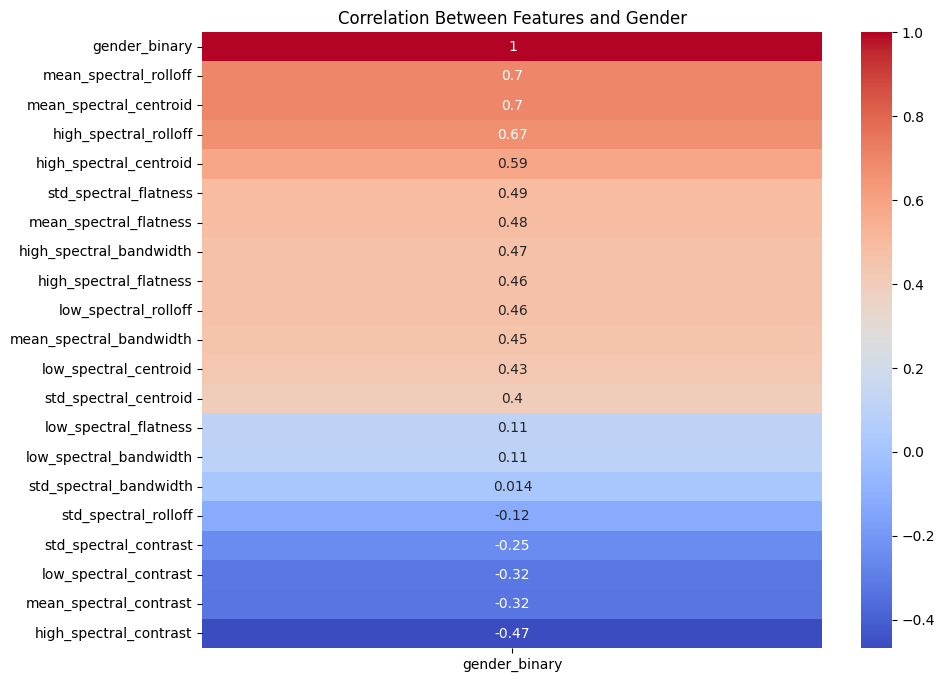

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode gender as binary
df['gender_binary'] = (df['gender'] == 'female_feminine').astype(int)

# Compute correlations
correlation_matrix = df.drop(columns=['path', 'gender']).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['gender_binary']].sort_values(by='gender_binary', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Gender')
plt.show()

#### Findings

From these quick tests we can see that there is a high correlation between gender and the following features:
- mean_spectral_centroid
- high_spectral_rolloff
- mean_spectral_rolloff
- high_spectral_centroid

## Feature selection

In [15]:
# Split feature and target variables into X and y dataframes

X = df[FEATURES]
y = df['gender']

print(X.shape)
print(y.shape)

(428, 20)
(428,)


In [16]:
# Encode y values which are currently either 'male_masculine' or 'female_feminine'

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_encoded = label_encoder.fit_transform(y)

# Print encoded labels and mapping
print("Encoded target values:", y_encoded)
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Encoded target values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label mapping: {'female_feminine': 0, 'male_masculine': 1}


In [17]:
# Test-train split

from sklearn.model_selection import train_test_split
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(342, 20) (86, 20) (342,) (86,)


## Train Simple Models

Below I've standardized the features. Not all models will use the standardized feature set.

In [18]:
from sklearn.preprocessing import StandardScaler

# Standardize the features (Logistic Regression performs better with standardized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[34  1]
 [ 4 47]]

Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.89      0.97      0.93        35
 male_masculine       0.98      0.92      0.95        51

       accuracy                           0.94        86
      macro avg       0.94      0.95      0.94        86
   weighted avg       0.94      0.94      0.94        86


Accuracy Score:
0.9418604651162791


#### With hyperparameter tuning

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers compatible with penalties
    'max_iter': [100, 200, 500]  # Convergence iterations
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# GridSearchCV
grid = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

# Train the best model
best_log_reg = grid.best_estimator_

# Evaluate on the test set
y_pred = best_log_reg.predict(X_test_scaled)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.9560528559249788

Confusion Matrix:
[[34  1]
 [ 4 47]]

Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.89      0.97      0.93        35
 male_masculine       0.98      0.92      0.95        51

       accuracy                           0.94        86
      macro avg       0.94      0.95      0.94        86
   weighted avg       0.94      0.94      0.94        86



c:\Users\vchap\Documents\Development\speaker-identification\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vchap\Documents\Development\speaker-identification\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\vchap\Documents\Development\speaker-identification\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Support Vector Machine

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the SVM model (default kernel is 'rbf')
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[35  0]
 [ 4 47]]

Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.90      1.00      0.95        35
 male_masculine       1.00      0.92      0.96        51

       accuracy                           0.95        86
      macro avg       0.95      0.96      0.95        86
   weighted avg       0.96      0.95      0.95        86


Accuracy Score:
0.9534883720930233


#### With hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

# Initialize GridSearchCV
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

# Train with best parameters
best_svm_model = grid.best_estimator_
y_pred_best = best_svm_model.predict(X_test_scaled)

# Evaluate the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.9765984654731458

Classification Report (Best Model):
                 precision    recall  f1-score   support

female_feminine       0.90      1.00      0.95        35
 male_masculine       1.00      0.92      0.96        51

       accuracy                           0.95        86
      macro avg       0.95      0.96      0.95        86
   weighted avg       0.96      0.95      0.95        86



### Gradient Boosting Machine

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred = gbm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[34  1]
 [ 7 44]]

Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.83      0.97      0.89        35
 male_masculine       0.98      0.86      0.92        51

       accuracy                           0.91        86
      macro avg       0.90      0.92      0.91        86
   weighted avg       0.92      0.91      0.91        86


Accuracy Score:
0.9069767441860465


#### With hyperparameter tuning

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

# Use the best model for predictions
best_gbm_model = grid.best_estimator_
y_pred = best_gbm_model.predict(X_test)

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validated Accuracy: 0.9765984654731458

Classification Report (Best Model):
                 precision    recall  f1-score   support

female_feminine       0.85      0.97      0.91        35
 male_masculine       0.98      0.88      0.93        51

       accuracy                           0.92        86
      macro avg       0.91      0.93      0.92        86
   weighted avg       0.93      0.92      0.92        86



### K-Nearest-Neighbours

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Default: Euclidean distance
knn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Confusion Matrix:
[[33  2]
 [ 2 49]]

Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.94      0.94      0.94        35
 male_masculine       0.96      0.96      0.96        51

       accuracy                           0.95        86
      macro avg       0.95      0.95      0.95        86
   weighted avg       0.95      0.95      0.95        86


Accuracy Score:
0.9534883720930233


#### With hyperparameter tuning

In [26]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Minkowski distance power parameter
}

# Initialize GridSearchCV
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Best parameters and model
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)

# Train with the best parameters
best_knn_model = grid.best_estimator_
y_pred_best = best_knn_model.predict(X_test_scaled)

# Evaluate the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1}
Best Cross-Validated Accuracy: 0.9648763853367435

Classification Report (Best Model):
                 precision    recall  f1-score   support

female_feminine       0.97      0.91      0.94        35
 male_masculine       0.94      0.98      0.96        51

       accuracy                           0.95        86
      macro avg       0.96      0.95      0.95        86
   weighted avg       0.95      0.95      0.95        86



c:\Users\vchap\Documents\Development\speaker-identification\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.96487639 0.96487639 0.95899403 0.95899403 0.95899403 0.95899403
 0.95021313 0.95021313 0.9443734  0.9443734         nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.96487639        nan 0.95899403
        nan 0.95899403        nan 0.95021313        nan 0.9443734 ]
  warnings.warn(


### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9302325581395349


#### With hyperparameter tuning

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best Cross-Validated Accuracy for Random Forest:", grid_rf.best_score_)

# Use the best model
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

KeyboardInterrupt: 

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
y_pred_nb = nb_model.predict(X_test_scaled)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

#### With hyperpamater tuning

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid_nb = {
    'var_smoothing': np.logspace(-9, 0, 10)  # Test different levels of variance smoothing
}

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Initialize GridSearchCV
grid_nb = GridSearchCV(estimator=nb_model, param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_nb.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters for Naive Bayes:", grid_nb.best_params_)
print("Best Cross-Validated Accuracy for Naive Bayes:", grid_nb.best_score_)

# Use the best model
best_nb_model = grid_nb.best_estimator_
y_pred_nb = best_nb_model.predict(X_test)

# Evaluate the model
print("\nNaive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

### Conclusion

It seems the Support Vector Machine model is the winner, with an accuracy of 97% when tuned.

## Ensemble model

In [36]:
# Define base models
estimators = [
    ('rf', best_rf_model),
    ('svc', best_svm_model),
    ('nb', best_nb_model)
]

### Voting

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=estimators, voting='hard')

voting_model.fit(X_train_scaled, y_train)
y_pred_voting = voting_model.predict(X_test_scaled)

print("Ensemble Model Accuracy:", accuracy_score(y_test, y_pred_voting))

### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stacking))

## Conclusion

From the tests shown above we can see it is possible to predict the gender of a speaker to a reasonable degree of accuracy using just simple structured data extracted from the recording.

In [29]:
import joblib

joblib.dump(best_svm_model, "svm.plk")

['svm.plk']